# Machine Learning - DBScan Clustering

## Import Libraries 

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

## Load Dataset 

In [2]:
df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "uciml/iris",
        "Iris.csv",
    )
print("Dataset berhasil dimuat.")
print("Lima data pertama:\n", df.head())

X_df = df.drop(['Id', 'Species'], axis=1)
X = X_df.values 
y_species = df['Species']

print(f"\nBentuk matriks fitur X: {X.shape}")

Dataset berhasil dimuat.
Lima data pertama:
    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Bentuk matriks fitur X: (150, 4)


## Visualisasi Data Asli 

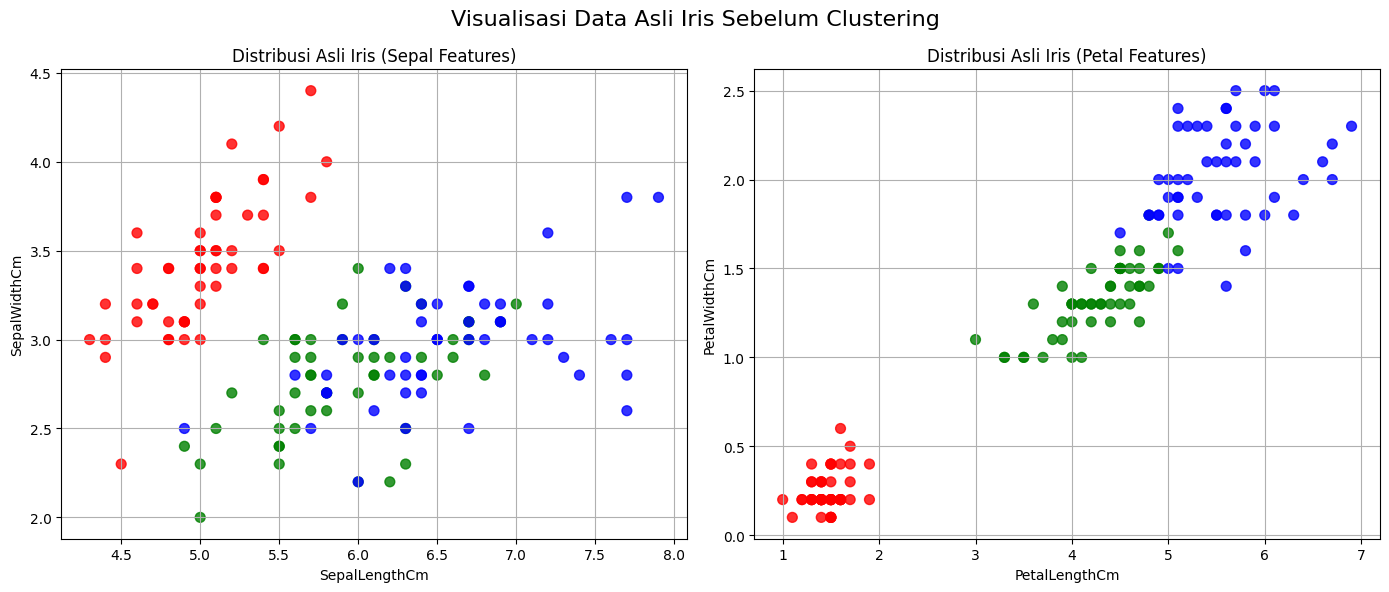

In [3]:
species_to_color = {
    'Iris-setosa': 'red',
    'Iris-versicolor': 'green',
    'Iris-virginica': 'blue'
}
colors = [species_to_color[s] for s in y_species]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.8)
plt.title('Distribusi Asli Iris (Sepal Features)')
plt.xlabel(X_df.columns[0])
plt.ylabel(X_df.columns[1])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 2], X[:, 3], c=colors, s=50, alpha=0.8)
plt.title('Distribusi Asli Iris (Petal Features)')
plt.xlabel(X_df.columns[2])
plt.ylabel(X_df.columns[3])
plt.grid(True)

plt.suptitle('Visualisasi Data Asli Iris Sebelum Clustering', fontsize=16)
plt.tight_layout()
plt.show()

## Fungsi Helper DBScan 

In [4]:
def euclidean_distance(point1, point2):
    """Menghitung jarak Euclidean antara dua titik."""
    return np.sqrt(np.sum((point1 - point2)**2))

def get_neighbors(X_data, point_index, eps, distance_matrix):
    """Menemukan indeks semua titik tetangga dalam radius eps dari titik tertentu menggunakan distance matrix."""
    neighbors = []
    for i in range(X_data.shape[0]):
        if distance_matrix[point_index, i] <= eps:
            neighbors.append(i)
    return neighbors


## DBScan Algorithm

- Mengimplementasikan algoritma DBSCAN 
- Menandai titik sebagai NOISE (-1) atau UNCLASSIFIED (0) pada awalnya
- Menemukan core point (titik dengan minimal min_pts tetangga dalam jarak eps)
- Memperluas cluster dari core point menggunakan pendekatan region growing
- Menandai titik sebagai bagian dari cluster (bilangan positif) atau noise

In [5]:
NOISE = -1
UNCLASSIFIED = 0

def dbscan_scratch(X_data, eps, min_pts):
    """
    Melakukan clustering DBSCAN dari awal.
    Mengembalikan array label cluster untuk setiap titik data.
    """
    num_points = X_data.shape[0]
    labels = [UNCLASSIFIED] * num_points
    cluster_id = 0

    # Precompute distance matrix for efficiency
    distance_matrix = np.array([[euclidean_distance(p1, p2) for p2 in X_data] for p1 in X_data])
    print("Matriks jarak telah dihitung sebelumnya.")

    for point_idx in range(num_points):
        if labels[point_idx] != UNCLASSIFIED:
            continue 

        # Temukan tetangga untuk titik saat ini
        neighbors_indices = get_neighbors(X_data, point_idx, eps, distance_matrix)

        if len(neighbors_indices) < min_pts:
            labels[point_idx] = NOISE 
            continue

        # Titik adalah core point, mulai cluster baru
        cluster_id += 1
        labels[point_idx] = cluster_id
        print(f"Titik {point_idx} adalah core point, memulai cluster {cluster_id}.")

        # Proses semua neighbors dari core point ini
        seed_queue = [n_idx for n_idx in neighbors_indices if n_idx != point_idx]

        head = 0
        while head < len(seed_queue):
            current_neighbor_idx = seed_queue[head]
            head += 1

            # Jika titik ini adalah noise, sekarang menjadi border point dari cluster ini
            if labels[current_neighbor_idx] == NOISE:
                labels[current_neighbor_idx] = cluster_id
                print(f"  Titik noise {current_neighbor_idx} menjadi border point untuk cluster {cluster_id}.")

            # Jika titik ini belum diklasifikasikan
            elif labels[current_neighbor_idx] == UNCLASSIFIED:
                labels[current_neighbor_idx] = cluster_id
                print(f"  Titik {current_neighbor_idx} ditambahkan ke cluster {cluster_id}.")

                # Jika titik tetangga ini juga core point, tambahkan tetangganya ke seed_queue
                current_neighbor_neighbors_indices = get_neighbors(X_data, current_neighbor_idx, eps, distance_matrix)
                if len(current_neighbor_neighbors_indices) >= min_pts:
                    print(f"    Titik {current_neighbor_idx} juga core point, memperluas cluster.")
                    for sub_neighbor_idx in current_neighbor_neighbors_indices:
                        if labels[sub_neighbor_idx] == UNCLASSIFIED or labels[sub_neighbor_idx] == NOISE:
                            seed_queue.append(sub_neighbor_idx)

    print(f"\nProses DBSCAN selesai. Jumlah cluster yang ditemukan (tidak termasuk noise): {cluster_id}")
    return np.array(labels)

## Parameter Tuning (minPts & Eps)

- Membuat fungsi plot_k_distance_graph untuk memilih parameter eps optimal
- Menghitung jarak ke tetangga ke-k untuk setiap titik (k = minPts - 1)
- Mengurutkan dan memplot jarak untuk mengidentifikasi titik siku
- Menetapkan minPts = 5 untuk dataset ini

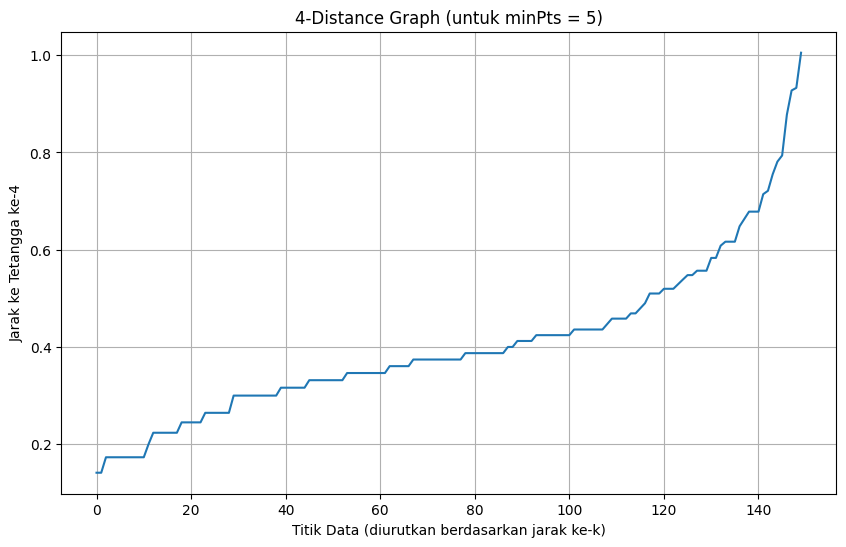

In [6]:
def plot_k_distance_graph(X_data, min_pts_val):
    """Menghitung dan memplot k-distance graph untuk membantu memilih Eps."""
    k = min_pts_val - 1
    if k <= 0:
        print("min_pts_val harus lebih besar dari 1 untuk k-distance graph.")
        return

    num_points = X_data.shape[0]
    k_distances = []

    distance_matrix = np.array([[euclidean_distance(p1, p2) for p2 in X_data] for p1 in X_data])

    for i in range(num_points):
        distances_to_others = sorted(distance_matrix[i])
        if len(distances_to_others) > k:
             k_distances.append(distances_to_others[k]) 

    k_distances_sorted = sorted(k_distances)

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted)
    plt.title(f'{k}-Distance Graph (untuk minPts = {min_pts_val})')
    plt.xlabel('Titik Data (diurutkan berdasarkan jarak ke-k)')
    plt.ylabel(f'Jarak ke Tetangga ke-{k}')
    plt.grid(True)
    plt.show()


chosen_min_pts = 5
plot_k_distance_graph(X, chosen_min_pts)


# Dengan Parameter yang dipilih jalankan DBScan

In [7]:
#titik siku ada dikisaran 0.4
eps_chosen = 0.42 
min_pts_chosen = chosen_min_pts

print(f"Menjalankan DBSCAN dengan eps = {eps_chosen} dan minPts = {min_pts_chosen}...")
labels = dbscan_scratch(X, eps=eps_chosen, min_pts=min_pts_chosen)

num_clusters_found = len(set(l for l in labels if l > 0))
num_noise_points = np.sum(labels == NOISE)

print(f"\nClustering Selesai.")
print(f"Label unik yang dihasilkan: {np.unique(labels)}")
print(f"Jumlah cluster yang ditemukan: {num_clusters_found}")
print(f"Jumlah titik noise: {num_noise_points}")

Menjalankan DBSCAN dengan eps = 0.42 dan minPts = 5...
Matriks jarak telah dihitung sebelumnya.
Titik 0 adalah core point, memulai cluster 1.
  Titik 4 ditambahkan ke cluster 1.
    Titik 4 juga core point, memperluas cluster.
  Titik 7 ditambahkan ke cluster 1.
    Titik 7 juga core point, memperluas cluster.
  Titik 10 ditambahkan ke cluster 1.
    Titik 10 juga core point, memperluas cluster.
  Titik 11 ditambahkan ke cluster 1.
    Titik 11 juga core point, memperluas cluster.
  Titik 17 ditambahkan ke cluster 1.
    Titik 17 juga core point, memperluas cluster.
  Titik 19 ditambahkan ke cluster 1.
    Titik 19 juga core point, memperluas cluster.
  Titik 21 ditambahkan ke cluster 1.
    Titik 21 juga core point, memperluas cluster.
  Titik 26 ditambahkan ke cluster 1.
    Titik 26 juga core point, memperluas cluster.
  Titik 27 ditambahkan ke cluster 1.
    Titik 27 juga core point, memperluas cluster.
  Titik 28 ditambahkan ke cluster 1.
    Titik 28 juga core point, memperluas c

## Visualisasi Hasil DBScan 

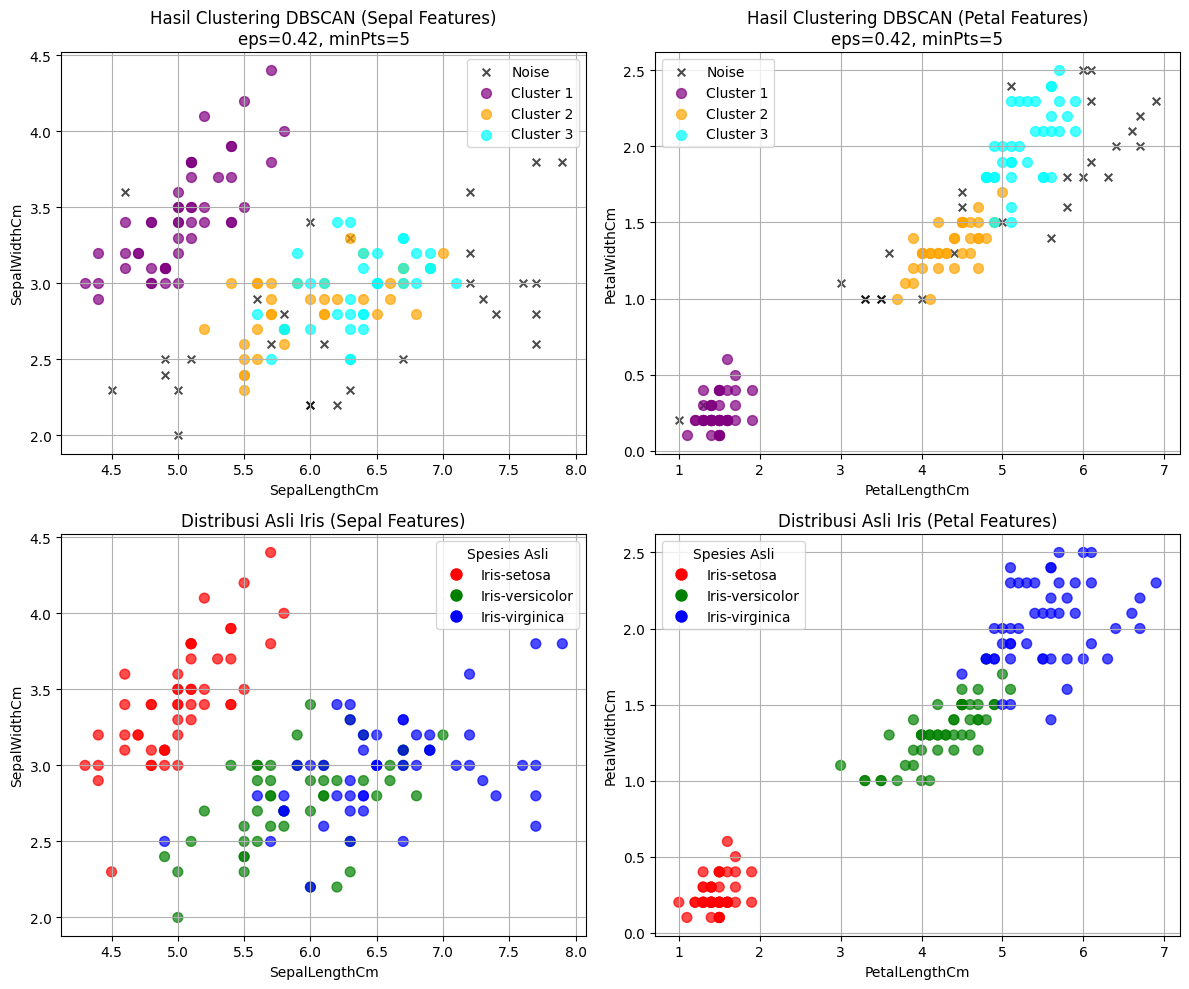

In [8]:
plt.figure(figsize=(12, 10))

cluster_colors = ['purple', 'orange', 'cyan', 'blue', 'green', ]

plt.subplot(2, 2, 1)
unique_labels = np.unique(labels)
for label in unique_labels:
    points_in_cluster = X[labels == label]
    if label == NOISE:
        plt.scatter(points_in_cluster[:, 0], points_in_cluster[:, 1], color='black', s=30, label='Noise', marker='x', alpha=0.7)
    else:
        color_idx = int(label) - 1
        if 0 <= color_idx < len(cluster_colors):
            point_color = cluster_colors[color_idx]
        else:
            point_color = 'gray'
        plt.scatter(points_in_cluster[:, 0], points_in_cluster[:, 1], s=50, label=f'Cluster {label}', alpha=0.7, color=point_color)

plt.title(f'Hasil Clustering DBSCAN (Sepal Features)\neps={eps_chosen}, minPts={min_pts_chosen}')

plt.xlabel(X_df.columns[0])
plt.ylabel(X_df.columns[1])
plt.legend()
plt.grid(True)

# Visualisasi untuk Petal features
plt.subplot(2, 2, 2) 
for label in unique_labels:
    points_in_cluster = X[labels == label]
    if label == NOISE:
        plt.scatter(points_in_cluster[:, 2], points_in_cluster[:, 3], color='black', s=30, label='Noise', marker='x', alpha=0.7)
    else:
        color_idx = int(label) - 1
        if 0 <= color_idx < len(cluster_colors):
            point_color = cluster_colors[color_idx]
        else:
            point_color = 'gray'
        plt.scatter(points_in_cluster[:, 2], points_in_cluster[:, 3], s=50, label=f'Cluster {label}', alpha=0.7, color=point_color)
plt.title(f'Hasil Clustering DBSCAN (Petal Features)\neps={eps_chosen}, minPts={min_pts_chosen}')
plt.xlabel(X_df.columns[2])
plt.ylabel(X_df.columns[3])
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.7)
plt.title('Distribusi Asli Iris (Sepal Features)')
plt.xlabel(X_df.columns[0])
plt.ylabel(X_df.columns[1])
if 'species_to_color' in locals():
    handles_original = [plt.Line2D([0], [0], marker='o', color='w', label=species,
                              markerfacecolor=color_val, markersize=10) for species, color_val in species_to_color.items()]
    plt.legend(title='Spesies Asli', handles=handles_original)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(X[:, 2], X[:, 3], c=colors, s=50, alpha=0.7)
plt.title('Distribusi Asli Iris (Petal Features)')
plt.xlabel(X_df.columns[2])
plt.ylabel(X_df.columns[3])
if 'species_to_color' in locals():
    plt.legend(title='Spesies Asli', handles=handles_original)
plt.grid(True)


plt.tight_layout()
plt.show()